In [98]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

In [99]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
import classifier_utilities as cu
import os

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"]="3";

In [3]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif'
]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',
]


landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))



In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from keras.optimizers import SGD
from keras.utils import plot_model
from keras import backend as K


def unet_model(n_classes=5, im_sz=160, n_channels=8, n_filters_start=32, growth_factor=2, upconv=True,
               metrics=['accuracy']):
    droprate=0.25
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    
    sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)
    return model


In [5]:
def fcn_tile_generator(l8_image_datasets, s1_image_datasets, dem_image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size, merge=True):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    # merge some of the labels
    if merge:
        label_image = merge_classes(label_image)

    c = r = 0
    i = 0
    
    label_proj = Proj(label_dataset.crs)
    l8_proj = Proj(l8_image_datasets[0].crs)
    s1_proj = Proj(s1_image_datasets[0].crs)

    # assuming all images have the same num of bands
    l8_band_count = l8_image_datasets[0].count  
    s1_band_count = s1_image_datasets[0].count
    dem_band_count = dem_image_datasets[0].count
    band_count = l8_band_count + s1_band_count + dem_band_count
    class_count = len(class_names)
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, band_count-1)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,tile_height,tile_width,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            r, c = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = l8_image_datasets[dataset_index].read(list(np.arange(1, l8_band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (l8_band_count, tile_width, tile_height):
                #print('wrong shape')
                #print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:
                # set medium developed to high dev
                #tile[tile == 3] = 2
                
                # taking off the QA band
                tile = tile[0:7]
                # reshape from raster format to image format and standardize according to image wide stats
                reshaped_tile = (reshape_as_image(tile)  - 982.5) / 1076.5
                
                # L8, S1, and DEM are all the same projection and area otherwise this wouldn't work
                # read in the sentinel-1 data 
                s1_tile = s1_image_datasets[dataset_index].read(list(np.arange(1, s1_band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
               
                # read in the DEM data 
                dem_tile = dem_image_datasets[dataset_index].read(list(np.arange(1, dem_band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
                
                if np.isnan(s1_tile).any() == True:
                    pass
                elif np.isnan(dem_tile).any() == True:
                    pass
                else:
                    # reshape from raster format to image format and standardize according to image wide stats
                    reshaped_s1_tile = (reshape_as_image(s1_tile)  - 0.10) / 0.088
                    # reshape from raster format to image format and standardize according to image wide stats
                    reshaped_dem_tile = (reshape_as_image(dem_tile)  - 31) / 16.5
                    
                    ### get label data
                    # find gps of that pixel within the image
                    (x, y) = l8_image_datasets[dataset_index].xy(r, c)

                    # convert the point we're sampling from to the same projection as the label dataset if necessary
                    if l8_proj != label_proj:
                        x,y = transform(l8_proj,label_proj,x,y)

                    # reference gps in label_image
                    
                    row, col = label_dataset.index(x,y)
                    label_masks = np.zeros((tile_height, tile_width, class_count))
                    flag = False
                    #use tile to make the masks
                    for h in range(tile_height):
                        if flag:
                            break
                        tileRow = row-buffer+h
                        for w in range(tile_width):
                            tileCol = col-buffer+w
                            if(label_image[0, tileRow, tileCol] == 0):
                                flag = True
                            else:
                                label_masks[h][w][label_image[0, tileRow, tileCol]-1] = 1
                    if flag:
                        pass
                    else:
                        label_batch[b] = label_masks
                        image_batch[b] = np.dstack( ( reshaped_tile, reshaped_s1_tile, reshaped_dem_tile ) )
                        b += 1
        yield (image_batch, label_batch)


In [6]:
batch_size = 25
epochs = 200
num_classes = len(class_names)

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count + dem_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(64, 64, 10)


In [7]:
train_px, val_px = cu.gen_pixel_locations(landsat_datasets, 100000, 30000, tile_side)

In [8]:
model = unet_model(n_classes=len(class_names), im_sz=tile_side, n_channels=img_bands, n_filters_start=64, growth_factor=2, upconv=True,
               metrics=['accuracy'])

In [9]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit_generator(generator=fcn_tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, train_px, batch_size, merge=False), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=fcn_tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, val_px, batch_size, merge=False),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/200
4000/4000 [==============================] - 3391s 848ms/step - loss: 2.0528 - acc: 0.2345 - val_loss: 1.9094 - val_acc: 0.4147
Epoch 2/200
4000/4000 [==============================] - 3340s 835ms/step - loss: 1.6895 - acc: 0.4616 - val_loss: 1.7090 - val_acc: 0.4685
Epoch 3/200
4000/4000 [==============================] - 3379s 845ms/step - loss: 1.5335 - acc: 0.5123 - val_loss: 1.5708 - val_acc: 0.5077
Epoch 4/200
4000/4000 [==============================] - 3346s 837ms/step - loss: 1.5913 - acc: 0.4929 - val_loss: 1.6635 - val_acc: 0.4889
Epoch 5/200
4000/4000 [==============================] - 3348s 837ms/step - loss: 1.5508 - acc: 0.5030 - val_loss: 1.6183 - val_acc: 0.4887
Epoch 6/200
4000/4000 [==============================] - 3344s 836ms/step - loss: 1.4710 - acc: 0.5277 - val_loss: 1.5418 - val_acc: 0.5094
Epoch 7/200
4000/4000 [==============================] - 3328s 832ms/step - loss: 1.5252 - acc: 0.5089 - val_loss: 1.5730 - val_acc: 0.5019
Epoch 8/200
4000/400

KeyboardInterrupt: 

In [19]:
predictions = model.predict_generator(generator=cu.tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
        label_dataset, tile_side, tile_side, val_px, batch_size, merge=False), 
                        steps=len(val_px) // batch_size,
                         verbose=1)


1200/1200 [==============================] - 190s 158ms/step


In [58]:
eval_generator = fcn_tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
                                label_dataset, tile_side, tile_side, val_px, batch_size=1, merge=False)

In [46]:
actual_pred = np.argmax(predictions, axis=3)
flatpred = actual_pred.flatten()

In [65]:
labels = np.empty(flatpred.shape)
count = 0
while count < len(labels)/4096:
    image_b, label_b = next(eval_generator)
    label_b = np.argmax(label_b, axis=3)
    label_b = label_b.flatten()
    labels[count:count+len(label_b)] = label_b
    count += len(label_b)

In [67]:
labels.shape

(122880000,)

In [68]:
pred_index = flatpred
label_index = labels

/host/Desktop/cnn_dev/florence_mapping/fcn/classifier_utilities.py:646: RuntimeWarning: invalid value encountered in true_divide
  cover_names.append(class_dict[cover_class])


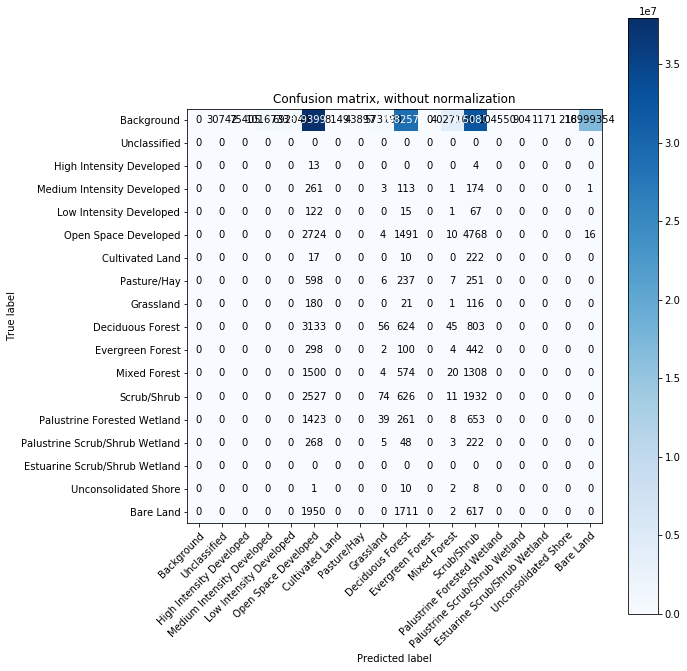

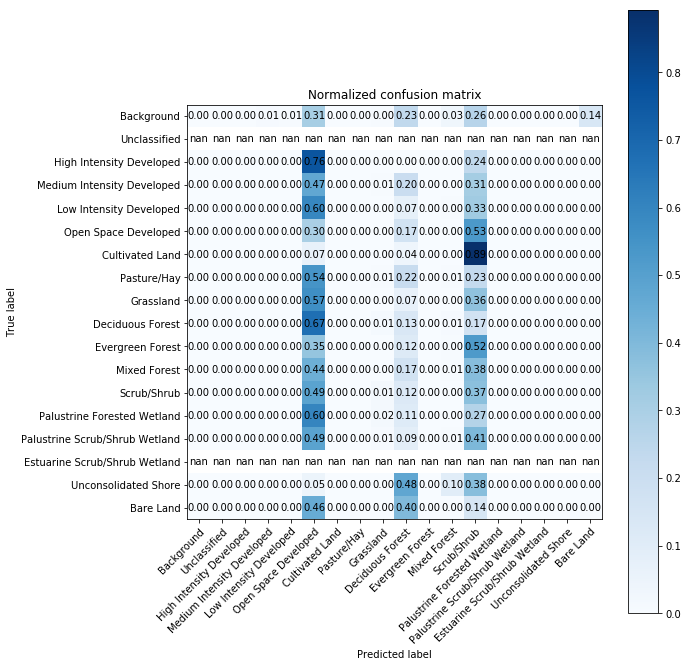

In [100]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
cu.plot_confusion_matrix(label_index.astype(int), pred_index.astype(int), classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
cu.plot_confusion_matrix(label_index.astype(int), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)